In [18]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(
    root = './data',
    train = True,
    download= True,
    transform=transform
)
test_dataset = datasets.FashionMNIST(
    root = './data',
    train = False,
    download= True,
    transform=transform
)

train_loader = DataLoader(train_dataset,batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=256, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 60000
Test size: 10000


In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,128),  #from 2D to 1D, input size 28*28= 784 and output size 128
            nn.ReLU(),
            nn.Linear(128,10)  #output size 10 for 10 classes
        ) 
    
    def forward(self, x):
        return self.net(x)
    
model = MLP()
print(model)

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
#loss func and optimizer
optimizer = optim.Adam(model.parameters(),lr= 0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
#train loop
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
num_epochs = 10

def train_epoch(model , loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1) #get the index of the max log-probability
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10, Train Loss: 0.2943, Test Accuracy: 0.8666
Epoch 2/10, Train Loss: 0.2805, Test Accuracy: 0.8728
Epoch 3/10, Train Loss: 0.2675, Test Accuracy: 0.8748
Epoch 4/10, Train Loss: 0.2609, Test Accuracy: 0.8785
Epoch 5/10, Train Loss: 0.2512, Test Accuracy: 0.8754
Epoch 6/10, Train Loss: 0.2427, Test Accuracy: 0.8807
Epoch 7/10, Train Loss: 0.2358, Test Accuracy: 0.8820
Epoch 8/10, Train Loss: 0.2250, Test Accuracy: 0.8826
Epoch 9/10, Train Loss: 0.2184, Test Accuracy: 0.8812
Epoch 10/10, Train Loss: 0.2130, Test Accuracy: 0.8656


In [9]:
#CNN
x, y = next(iter(train_loader))
print("Input shape:", x.shape)  #torch.Size([128, 1, 28, 28])

Input shape: torch.Size([128, 1, 28, 28])


In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),  #input channel 1, output channel 32, kernel size 3x3
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #reduce size by half
            
            nn.Conv2d(32,64,3, padding=1),  #input channel 32, output channel 64, kernel size 3x3
            nn.ReLU(),
            nn.MaxPool2d(2,2)  # output (64,7,7)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,num_classes)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}") 

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print("Best model saved with accuracy: {:.4f}".format(best_acc))

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch 1/10, Train Loss: 0.5331, Test Accuracy: 0.8662
Best model saved with accuracy: 0.8662
Epoch 2/10, Train Loss: 0.3424, Test Accuracy: 0.8874
Best model saved with accuracy: 0.8874
Epoch 3/10, Train Loss: 0.2927, Test Accuracy: 0.8986
Best model saved with accuracy: 0.8986
Epoch 4/10, Train Loss: 0.2618, Test Accuracy: 0.9059
Best model saved with accura

In [11]:
#Confusion Matrix + Error Analysis

model = CNN().to(device)
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [12]:
all_preds = []
all_labels = []
all_probs = []  #confidence scores

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)                      # (B,10)
        probs = torch.softmax(logits, dim=1)   # (B,10)

        preds = probs.argmax(dim=1).cpu()      # (B,)
        conf  = probs.max(dim=1).values.cpu()  # (B,) 

        all_preds.append(preds)
        all_labels.append(y)   
        all_probs.append(conf)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs)

print("Total test samples:", len(all_labels))
print("Accuracy from best model:", (all_preds == all_labels).float().mean().item())

Total test samples: 10000
Accuracy from best model: 0.9182000160217285


<Figure size 1000x1000 with 0 Axes>

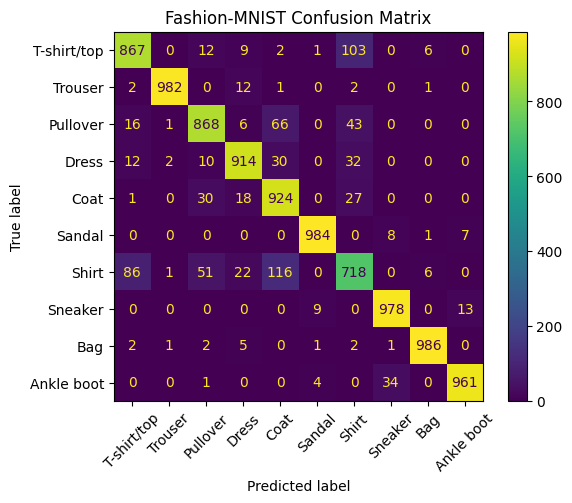

In [15]:
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation=45, cmap=None) 
plt.title("Fashion-MNIST Confusion Matrix")
plt.show()



In [17]:
wrong_mask = (all_preds != all_labels)
wrong_indices = wrong_mask.nonzero(as_tuple=True)[0]

# take top 20 most confident wrong predictions
topk = 20
wrong_conf = all_probs[wrong_indices]
sorted_wrong = wrong_indices[torch.argsort(wrong_conf, descending=True)]
top_wrong = sorted_wrong[:topk]


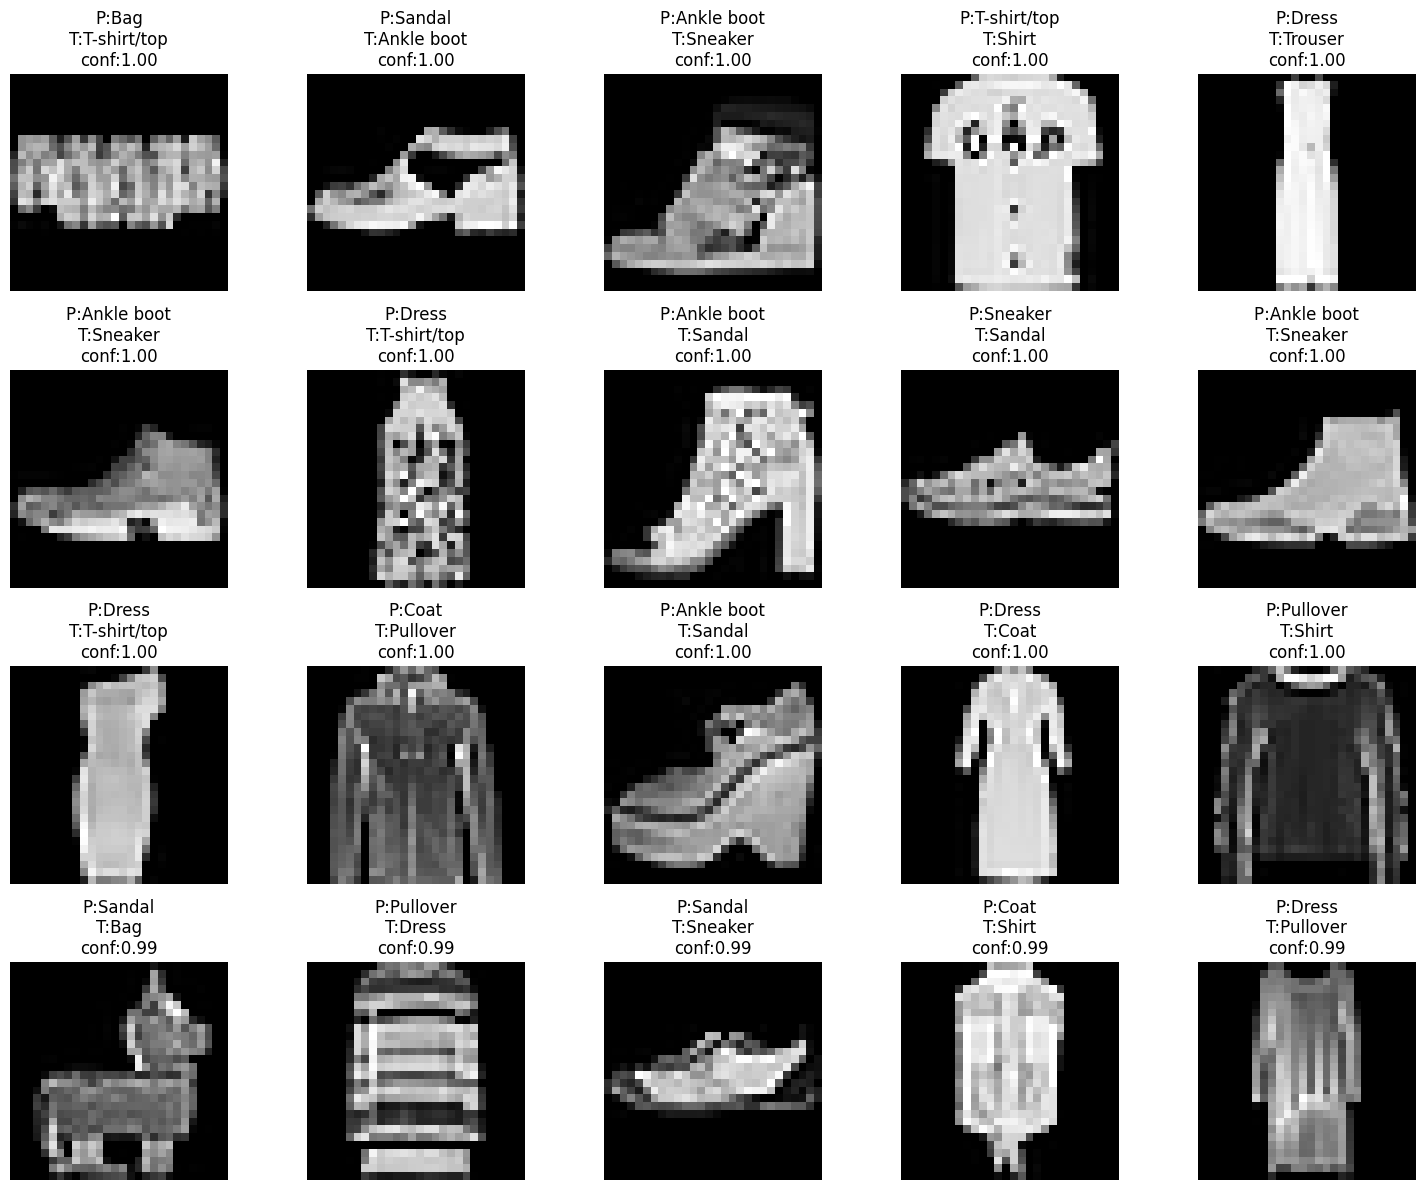

In [19]:
def show_top_wrong(test_ds, indices, preds, labels, probs, class_names, cols=5):
    rows = math.ceil(len(indices) / cols)
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, idx in enumerate(indices):
        img, true = test_ds[int(idx)]
        pred = int(preds[int(idx)])
        tru  = int(labels[int(idx)])
        conf = float(probs[int(idx)])

        # img: (1,28,28) tensor -> 轉成 (28,28)
        img2 = img.squeeze(0)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img2, cmap="gray")
        ax.set_title(f"P:{class_names[pred]}\nT:{class_names[tru]}\nconf:{conf:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_top_wrong(test_dataset, top_wrong, all_preds, all_labels, all_probs, class_names)
